# Customer Service Chatbot with DialogGPT for Conversational Intents

This Jupyter Notebook updates `evaluate_chatbot_data_dialoggpt_twitter_trained.ipynb` to fix syntax errors and a class mismatch error in model evaluation (5 classes vs. 11 target names). It uses Microsoft’s DialogGPT for conversational intents (greeting, farewell, small_talk, compliment, weather_query) and DistilBERT for trucking-specific intents (delivery_status, billing_issue, account_update, service_inquiry, fuel_card_query, general_query). Trains on Twitter dataset (`tweets.csv` or `trucking_chatbot_test_dataset.csv`) with interactive ipywidgets UI.

## Objectives
- Inspect Twitter dataset for intents and entities (e.g., location, company).
- Train DistilBERT for intent classification.
- Fine-tune DialogGPT on conversational Twitter data.
- Evaluate DistilBERT with accuracy, F1-score, confusion matrix, and dialogue success rate.
- Implement hybrid dialogue management with DialogGPT and DistilBERT.
- Provide interactive UI for customer interaction.

## Requirements
- Python 3.8 (recommended; 3.9 also compatible)
- Install: `pip install transformers==4.44.2 torch==2.5.0 pandas==2.2.3 numpy==2.1.1 scikit-learn==1.5.2 datasets==3.0.1 seaborn==0.13.2 matplotlib==3.9.2 ipywidgets==8.1.5`
- For GPU: `pip install torch==2.5.0+cu121 --index-url https://download.pytorch.org/whl/cu121`
- Place `trucking_chatbot_test_dataset.csv` or `tweets.csv` in the directory.
- Enable widgets: `jupyter nbextension enable --py widgetsnbextension`

## Notes
- Dataset: https://www.kaggle.com/thoughtvector/customer-support-on-twitter
- Reflects tariffs/Moody’s downgrade in billing/fuel inquiries.
- Professional responses with dynamic DialogGPT conversation.
- Date: May 29, 2025, 1:44 PM EDT


In [1]:
!pip install transformers==4.44.2 torch==2.6.0 pandas==2.2.2 numpy==1.25.0 scikit-learn==1.5.2 datasets==3.0.1 seaborn==0.13.2 matplotlib==3.9.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 135.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [2]:
pip install --no-cache-dir --upgrade jaraco.functools

In [3]:
pip install --no-cache-dir --upgrade accelerate

In [28]:
!pip install ipywidgets==7.7.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 4.0.14
    Uninstalling widgetsnbextension-4.0.14:
      Successfully uninstalled widgetsnbextension-4.0.14
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 8.1.5
    Uninstalling ipywidgets-8.1.5:
      Successfully uninstalled ipywidgets-8.1.5


## Step 1: Import Libraries

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from datasets import Dataset, ClassLabel
import torch
import json
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import defaultdict
import random
import re
from datetime import datetime
import os
from matplotlib.pyplot import text
%matplotlib inline


## Step 2: Inspect and Preprocess Dataset

Load Twitter dataset, add conversational examples, label intents/entities. Ensure all intents are preserved.


In [9]:
def inspect_dataset(file_path='/content/sample_data/twcs_lessrecords.csv'):
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print('Dataset not found. Using Twitter dataset.')
        try:
            df = pd.read_csv('tweets.csv')
        except FileNotFoundError:
            print('Download from: https://www.kaggle.com/thoughtvector/customer-support-on-twitter')
            data = {
                'text': [
                    'Where is my shipment from Speedway?', 'Why is my Comdata bill so high?',
                    'Need to update my address for IFTA', 'What are your hauling rates?',
                    'Help with my account', 'Hello', 'How are you', 'How can I help you',
                    'Track my cargo', 'Overcharged on Comdata invoice', 'Hi there',
                    'Change my contact info', 'Tell me about Comdata services', 'Lost my shipment',
                    'Good morning', 'Thanks for your help', 'Bye', 'What’s new?',
                    'How’s it going?', 'How’s your day going?', 'Any big plans?',
                    'How’s the trucking life?', 'You’re awesome!', 'Great job!',
                    'How’s the weather there?', 'Is it raining?'
                ],
                'intent': [
                    'delivery_status', 'billing_issue', 'account_update', 'service_inquiry',
                    'general_query', 'greeting', 'greeting', 'greeting', 'delivery_status',
                    'billing_issue', 'greeting', 'account_update', 'fuel_card_query',
                    'general_query', 'greeting', 'farewell', 'farewell', 'small_talk',
                    'small_talk', 'small_talk', 'small_talk', 'small_talk', 'compliment',
                    'compliment', 'weather_query', 'weather_query'
                ]
            }
            df = pd.DataFrame(data)

    # Define expected intents
    expected_intents = ['delivery_status', 'billing_issue', 'account_update', 'service_inquiry', 'fuel_card_query', 'general_query', 'greeting', 'farewell', 'small_talk', 'compliment', 'weather_query']

    # Check for null values
    if 'text' in df.columns:
        df = df.dropna(subset=['text'])
    if 'intent' in df.columns:
        df = df.dropna(subset=['intent'])

    keywords = ['delivery', 'shipment', 'cargo', 'bill', 'invoice', 'payment', 'account', 'service', 'hauling', 'truck', 'comdata', 'ifta', 'speedway', 'fuel', 'tax', 'station', 'hello', 'hi', 'how', 'good', 'bye', 'thanks', 'new', 'day', 'plans', 'awesome', 'great', 'weather', 'rain']
    if 'text' in df.columns:
        df = df[df['text'].str.contains('|'.join(keywords), case=False, na=False)]

    if 'intent' not in df.columns:
        def label_intent(text):
            text = text.lower()
            if any(word in text for word in ['hello', 'hi', 'how are you', 'how can i help', 'good morning', 'good afternoon']):
                return 'greeting'
            elif any(word in text for word in ['goodbye', 'bye', 'thanks', 'thank you']):
                return 'farewell'
            elif any(word in text for word in ['what’s new', 'how’s it going', 'how’s your day', 'any big plans', 'trucking life']):
                return 'small_talk'
            elif any(word in text for word in ['awesome', 'great job', 'you rock']):
                return 'compliment'
            elif any(word in text for word in ['weather', 'rain', 'sunny']):
                return 'weather_query'
            elif any(word in text for word in ['delivery', 'shipment', 'track', 'cargo']):
                return 'delivery_status'
            elif any(word in text for word in ['bill', 'invoice', 'payment', 'charge']):
                return 'billing_issue'
            elif any(word in text for word in ['update', 'change', 'address', 'contact']):
                return 'account_update'
            elif any(word in text for word in ['service', 'rate', 'hauling']):
                return 'service_inquiry'
            elif any(word in text for word in ['comdata', 'ifta', 'fuel', 'tax']):
                return 'fuel_card_query'
            else:
                return 'general_query'
        df['intent'] = df['text'].apply(label_intent)

    def extract_entities(text):
        entities = []
        text = text.lower()
        if 'speedway' in text:
            entities.append({'entity': 'location', 'value': 'Speedway'})
        if 'comdata' in text:
            entities.append({'entity': 'company', 'value': 'Comdata'})
        if 'ifta' in text:
            entities.append({'entity': 'regulation', 'value': 'IFTA'})
        return entities

    df['entities'] = df['text'].apply(extract_entities)

    # Ensure all intents and sufficient samples
    missing_intents = [intent for intent in expected_intents if intent not in df['intent'].unique()]
    intent_counts = df['intent'].value_counts()
    if missing_intents or any(count < 5 for count in intent_counts.get(expected_intents, [0])):
        print(f'Warning: Missing intents {missing_intents} or low sample counts {intent_counts.to_dict()}. Adding placeholders.')
        placeholder_data = []
        for intent in expected_intents:
            current_count = intent_counts.get(intent, 0)
            if current_count < 5:
                for _ in range(5 - current_count):
                    if intent == 'compliment':
                        placeholder_data.append({'text': f'You guys are {random.choice(["great", "awesome", "fantastic"])}!', 'intent': 'compliment', 'entities': []})
                    elif intent == 'weather_query':
                        placeholder_data.append({'text': f'Is it {random.choice(["raining", "sunny", "snowing"])} on my route?', 'intent': 'weather_query', 'entities': []})
                    elif intent == 'farewell':
                        placeholder_data.append({'text': f'{random.choice(["Thanks, bye", "Goodbye", "See ya"])}!', 'intent': 'farewell', 'entities': []})
                    elif intent == 'small_talk':
                        placeholder_data.append({'text': f'{random.choice(["How’s the day going?", "What’s new with you?", "How’s trucking?"])}', 'intent': 'small_talk', 'entities': []})
                    elif intent == 'greeting':
                        placeholder_data.append({'text': f'{random.choice(["Hello", "Hi", "Good morning"])}!', 'intent': 'greeting', 'entities': []})
                    elif intent == 'delivery_status':
                        placeholder_data.append({'text': f'Track my shipment {random.randint(100, 999)}', 'intent': 'delivery_status', 'entities': []})
                    elif intent == 'billing_issue':
                        placeholder_data.append({'text': f'Why is my bill ${random.randint(100, 1000)}?', 'intent': 'billing_issue', 'entities': []})
                    elif intent == 'account_update':
                        placeholder_data.append({'text': f'Update my {random.choice(["address", "contact", "email"])}', 'intent': 'account_update', 'entities': []})
                    elif intent == 'service_inquiry':
                        placeholder_data.append({'text': f'What are your {random.choice(["rates", "services", "routes"])}?', 'intent': 'service_inquiry', 'entities': []})
                    elif intent == 'fuel_card_query':
                        placeholder_data.append({'text': f'Issue with my {random.choice(["Comdata card", "IFTA", "fuel account"])}', 'intent': 'fuel_card_query', 'entities': [{'entity': 'company', 'value': 'Comdata'}]})
                    elif intent == 'general_query':
                        placeholder_data.append({'text': f'Need help with {random.choice(["something", "my account", "a question"])}', 'intent': 'general_query', 'entities': []})
        if placeholder_data:
            df = pd.concat([df, pd.DataFrame(placeholder_data)], ignore_index=True)

    print('Dataset Shape:', df.shape)
    print('Columns:', df.columns.tolist())
    print('Sample Rows:\n', df.head())
    print('Missing Values:\n', df.isnull().sum())
    print('Intent Distribution:\n', df['intent'].value_counts())
    print('Unique Intents:', sorted(df['intent'].unique()))
    print('Entity Samples:\n', df[df['entities'].apply(len) > 0][['text', 'entities']].head())
    return df

df = inspect_dataset()

Dataset Shape: (56843, 9)
Columns: ['tweet_id', 'author_id', 'inbound', 'created_at', 'text', 'response_tweet_id', 'in_response_to_tweet_id', 'intent', 'entities']
Sample Rows:
    tweet_id   author_id inbound                      created_at  \
0       2.0      115712    True  Tue Oct 31 22:11:45 +0000 2017   
1       6.0  sprintcare   False  Tue Oct 31 21:46:24 +0000 2017   
2       8.0      115712    True  Tue Oct 31 21:45:10 +0000 2017   
3      11.0  sprintcare   False  Tue Oct 31 22:10:35 +0000 2017   
4      16.0      115713    True  Tue Oct 31 20:00:43 +0000 2017   

                                                text response_tweet_id  \
0      @sprintcare and how do you propose we do that               NaN   
1  @115712 Can you please send us a private messa...               5,7   
2          @sprintcare is the worst customer service            9,6,10   
3  @115713 This is saddening to hear. Please shoo...               NaN   
4  @sprintcare Since I signed up with you....Sinc

## Step 3: Prepare DialogGPT Training Data


In [4]:
def prepare_dialoggpt_training_data(df):
    conversational_intents = ['greeting', 'farewell', 'small_talk', 'compliment', 'weather_query']
    df_conversational = df[df['intent'].isin(conversational_intents)][['text', 'intent']]

    # Validate dataset
    if df_conversational.empty:
        raise ValueError("No conversational intents found in dataset. Check Cell 2 output.")

    # Check intent distribution
    intent_counts = df_conversational['intent'].value_counts()
    print('Conversational Intent Distribution:')
    for intent in conversational_intents:
        count = intent_counts.get(intent, 0)
        print(f'{intent}: {count}')
        if count < 5:
            raise ValueError(f"Intent {intent} has {count} samples (<5). Add more samples in Cell 2.")

    response_map = {
        'greeting': [
            'Hello! How can I assist you with your trucking needs today?',
            'Hi there! Ready to help with your shipments or account!',
            'Good to hear from you! What’s up?'
        ],
        'farewell': [
            'Goodbye! Stay safe on the road.',
            'Thanks for connecting!'
        ],
        'small_talk': [
            'My day’s going smoothly, thanks! How’s yours?',
            'Trucking life’s always moving! How’s it like for you?',
            'Just keeping the wheels turning! Got any big plans?',
            'All’s good here! What’s new with you?'
        ],
        'compliment': [
            'Thanks, you’re awesome too! Need help with anything?',
            'Appreciate that! What can I do for you today?'
        ],
        'weather_query': [
            'Can’t see the skies, but I can check your route! Where are you headed?',
            'Weather’s a mystery here, but I’m ready to help! What’s your destination?'
        ]
    }

    dialogues = []
    for _, row in df_conversational.iterrows():
        user_input = row['text']
        intent = row['intent']
        response = random.choice(response_map[intent])
        dialogues.append({'input': user_input, 'response': response})

    dialogue_df = pd.DataFrame(dialogues)
    dataset = Dataset.from_pandas(dialogue_df)

    # Manual train/eval split (80/20)
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    split_idx = int(0.8 * len(indices))
    train_indices = indices[:split_idx]
    eval_indices = indices[split_idx:]
    train_dataset = dataset.select(train_indices)
    eval_dataset = dataset.select(eval_indices)

    os.makedirs('data', exist_ok=True)
    dialogue_df.to_csv('data/dialoggpt_dialogues.csv', index=False)

    print(f'DialogGPT training data prepared: {len(dialogue_df)} dialogue pairs.')
    print(f'Train dataset size: {len(train_dataset)}, Eval dataset size: {len(eval_dataset)}')
    return train_dataset, eval_dataset

dialoggpt_train_dataset, dialoggpt_eval_dataset = prepare_dialoggpt_training_data(df)

Conversational Intent Distribution:
greeting: 36847
farewell: 4701
small_talk: 5
compliment: 145
weather_query: 1530
DialogGPT training data prepared: 43228 dialogue pairs.
Train dataset size: 34582, Eval dataset size: 8646


## Step 4: Fine-Tune DialogGPT


In [10]:
import torch
import os

def load_saved_model(model_path='./dialoggpt_model'):
    """Load a saved DialogGPT model and tokenizer."""
    try:
        if not os.path.exists(model_path):
            print(f"No saved model found at {model_path}. Using pretrained model.")
            return None, None
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForCausalLM.from_pretrained(model_path)
        tokenizer.pad_token = tokenizer.eos_token
        print(f"Loaded model and tokenizer from {model_path}.")
        return model, tokenizer
    except Exception as e:
        print(f"Error loading saved model: {e}")
        return None, None

def fine_tune_dialoggpt(train_dataset, eval_dataset):
    # Try loading saved model first
    model, tokenizer = load_saved_model()
    if model is not None and tokenizer is not None:
        return model, tokenizer

    # If no saved model, proceed with fine-tuning
    model_name = 'microsoft/DialoGPT-medium'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(model_name)

    def preprocess_dialogues(example):
        try:
            conversation = f"{example['input']} {tokenizer.eos_token} {example['response']}"
            tokenized = tokenizer(
                conversation,
                padding='max_length',
                truncation=True,
                max_length=128,
                return_tensors='pt'
            )
            result = {
                'input_ids': tokenized['input_ids'].squeeze(0),
                'attention_mask': tokenized['attention_mask'].squeeze(0),
                'labels': tokenized['input_ids'].squeeze(0).clone()
            }
            return result
        except Exception as e:
            print(f'Error in preprocess_dialogues: {e}')
            raise

    try:
        tokenized_train_dataset = train_dataset.map(
            preprocess_dialogues,
            remove_columns=['input', 'response'],
            desc="Tokenizing train dataset",
            disable_progress_bar=True
        )
        tokenized_eval_dataset = eval_dataset.map(
            preprocess_dialogues,
            remove_columns=['input', 'response'],
            desc="Tokenizing eval dataset",
            disable_progress_bar=True
        )
        tokenized_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
        tokenized_eval_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
    except Exception as e:
        print(f'Error tokenizing dataset: {e}')
        return None, None

    training_args = TrainingArguments(
        output_dir='./dialoggpt_results',
        num_train_epochs=3,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        warmup_steps=10,
        weight_decay=0.01,
        logging_dir='./dialoggpt_logs',
        logging_steps=20,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        fp16=torch.cuda.is_available(),
        dataloader_num_workers=0
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_eval_dataset
    )

    try:
        trainer.train()
        trainer.save_model('./dialoggpt_model')
        tokenizer.save_pretrained('./dialoggpt_model')
        print('DialogGPT model fine-tuned and saved.')
        return model, tokenizer
    except Exception as e:
        print(f'Error fine-tuning DialogGPT: {e}')
        print('Falling back to pretrained DialogGPT model.')
        return None, None

dialoggpt_model, dialoggpt_tokenizer = fine_tune_dialoggpt(dialoggpt_train_dataset, dialoggpt_eval_dataset)
if dialoggpt_model is None:
    print('Using pretrained DialogGPT due to fine-tuning error.')
    dialoggpt_model = AutoModelForCausalLM.from_pretrained('microsoft/DialoGPT-medium')
    dialoggpt_tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-medium')
    dialoggpt_tokenizer.pad_token = dialoggpt_tokenizer.eos_token

Loaded model and tokenizer from ./dialoggpt_model.


Cell 5: Test Inference:
To test the loaded model for inference

In [6]:
def generate_response(input_text, model, tokenizer, max_length=50):
    inputs = tokenizer(input_text + tokenizer.eos_token, return_tensors='pt', padding=True, truncation=True)
    input_ids = inputs['input_ids'].to(model.device)
    attention_mask = inputs['attention_mask'].to(model.device)
    outputs = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=max_length,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=True,
        top_p=0.9
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=False)
    return response.split(tokenizer.eos_token)[-2].strip()

# Test the model
test_inputs = ["Hello!", "How’s the weather there?", "You’re awesome!"]
for input_text in test_inputs:
    response = generate_response(input_text, dialoggpt_model, dialoggpt_tokenizer)
    print(f"Input: {input_text}\nResponse: {response}\n")

Input: Hello!
Response: Hello! How can I assist you with your trucking needs today?

Input: How’s the weather there?
Response: It’s a good question! Weather is important here! What’s up?

Input: You’re awesome!
Response: Well thanks for that! I'll pass on your kind words to our team /AC



## Step 5: Preprocess for DistilBERT

Ensure all intents are included in the tokenized dataset and label_map.


In [13]:
def preprocess_data(df):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

    # Create label_map with all expected intents
    expected_intents = ['delivery_status', 'billing_issue', 'account_update', 'service_inquiry', 'fuel_card_query', 'general_query', 'greeting', 'farewell', 'small_talk', 'compliment', 'weather_query']
    label_map = {label: idx for idx, label in enumerate(sorted(expected_intents))}

    # Verify 'intent' column exists
    if 'intent' not in df.columns:
        raise ValueError("'intent' column missing in DataFrame. Check Cell 2 output.")

    # Filter dataset to include only expected intents
    df_filtered = df[df['intent'].isin(expected_intents)][['text', 'intent']].copy()

    # Check for empty dataset
    if df_filtered.empty:
        raise ValueError("Filtered dataset is empty. Check Cell 2 filtering or intent distribution.")

    # Check for missing intents and warn
    present_intents = df_filtered['intent'].unique()
    missing_intents = [intent for intent in expected_intents if intent not in present_intents]
    if missing_intents:
        print(f'Warning: Intents {missing_intents} missing in dataset after filtering.')

    dataset = Dataset.from_pandas(df_filtered)

    # Validate dataset size
    if len(dataset) == 0:
        raise ValueError("Dataset is empty after conversion. Check Cell 2 output.")

    # Compute label distribution
    label_counts = pd.Series([label_map.get(x['intent'], -1) for x in dataset]).value_counts()
    print('Label Distribution in Dataset (Label ID: Count):')
    for label_id, count in label_counts.items():
        if label_id == -1:
            print(f'Invalid Labels: {count}')
        else:
            intent = list(label_map.keys())[list(label_map.values()).index(label_id)]
            print(f'{intent} ({label_id}): {count}')

    # Check for invalid or insufficient labels
    if -1 in label_counts:
        raise ValueError(f"Invalid intents found: {label_counts[-1]} samples not in {expected_intents}.")
    min_samples = 5
    low_sample_labels = {label_id: count for label_id, count in label_counts.items() if count < min_samples and label_id != -1}
    if low_sample_labels:
        low_intents = {list(label_map.keys())[list(label_map.values()).index(k)]: v for k, v in low_sample_labels.items()}
        raise ValueError(f"Intents with < {min_samples} samples: {low_intents}. Add more samples in Cell 2.")

    # Tokenize and rename 'intent' to 'labels'
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.rename_column('intent', 'labels')
    tokenized_dataset = tokenized_dataset.map(lambda x: {'labels': label_map[x['labels']]})
    tokenized_dataset = tokenized_dataset.cast_column('labels', ClassLabel(names=list(label_map.keys())))

    # Verify dataset features
    print('Dataset Features:\n', tokenized_dataset.features)
    return tokenized_dataset, label_map, tokenizer

dataset, label_map, tokenizer = preprocess_data(df)
print(f'Label Map: {label_map}')


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Label Distribution in Dataset (Label ID: Count):
greeting (7): 36847
general_query (6): 7932
farewell (4): 4701
service_inquiry (8): 2235
weather_query (10): 1530
account_update (0): 1442
delivery_status (3): 1093
billing_issue (1): 837
compliment (2): 145
fuel_card_query (5): 76
small_talk (9): 5


Map:   0%|          | 0/56843 [00:00<?, ? examples/s]

Map:   0%|          | 0/56843 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/56843 [00:00<?, ? examples/s]

Dataset Features:
 {'text': Value(dtype='string', id=None), 'labels': ClassLabel(names=['account_update', 'billing_issue', 'compliment', 'delivery_status', 'farewell', 'fuel_card_query', 'general_query', 'greeting', 'service_inquiry', 'small_talk', 'weather_query'], id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Label Map: {'account_update': 0, 'billing_issue': 1, 'compliment': 2, 'delivery_status': 3, 'farewell': 4, 'fuel_card_query': 5, 'general_query': 6, 'greeting': 7, 'service_inquiry': 8, 'small_talk': 9, 'weather_query': 10}


## Step 6: Train DistilBERT Model

Ensure model is trained with correct number of labels.


In [14]:
def train_model(dataset, label_map):
    # Get unique labels in dataset
    unique_labels = sorted(set(dataset['labels']))
    num_labels = len(unique_labels)
    print(f'Training with {num_labels} unique labels: {unique_labels}')

    # Validate label consistency
    expected_num_labels = len(label_map)
    if num_labels != expected_num_labels:
        print(f'Warning: Dataset has {num_labels} labels, but label_map has {expected_num_labels}.')

    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)

    # Manual stratified split using sklearn
    try:
        # Extract features and labels
        indices = list(range(len(dataset)))
        labels = [dataset[i]['labels'] for i in indices]
        train_indices, eval_indices = train_test_split(
            indices,
            test_size=0.2,
            stratify=labels,
            random_state=42
        )
        train_dataset = dataset.select(train_indices)
        eval_dataset = dataset.select(eval_indices)
        print(f'Train dataset size: {len(train_dataset)}, Eval dataset size: {len(eval_dataset)}')
    except Exception as e:
        print(f'Error during dataset split: {e}')
        return None, None, None, None, unique_labels

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        fp16=torch.cuda.is_available(),
        dataloader_num_workers=0
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )
    try:
        trainer.train()
        trainer.save_model('./chatbot_model')
        return trainer, model, train_dataset, eval_dataset, unique_labels
    except Exception as e:
        print(f'Error training DistilBERT model: {e}')
        return None, None, None, None, unique_labels  # Return 5 values

trainer, model, train_dataset, eval_dataset, unique_labels = train_model(dataset, label_map)
if trainer is None:
    raise RuntimeError('Failed to train DistilBERT model.')
with open('label_map.json', 'w') as f:
    json.dump(label_map, f)


Training with 11 unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train dataset size: 45474, Eval dataset size: 11369


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: nisheeth_g2000 (nisheeth_g2000-self) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.022800,0.121493
2,0.003900,0.062022
3,0.061500,0.057328


## Step 7: Evaluate Model

Fix class mismatch by specifying labels in classification_report.


Accuracy: 0.9912
Classification Report:
                 precision    recall  f1-score   support

 account_update       0.98      1.00      0.99       288
  billing_issue       0.98      0.99      0.98       167
     compliment       1.00      0.83      0.91        29
delivery_status       0.98      0.98      0.98       219
       farewell       1.00      1.00      1.00       940
fuel_card_query       0.93      0.93      0.93        15
  general_query       0.97      0.99      0.98      1587
       greeting       1.00      0.99      1.00      7370
service_inquiry       0.97      0.96      0.96       447
     small_talk       0.00      0.00      0.00         1
  weather_query       0.98      0.97      0.98       306

       accuracy                           0.99     11369
      macro avg       0.89      0.88      0.88     11369
   weighted avg       0.99      0.99      0.99     11369




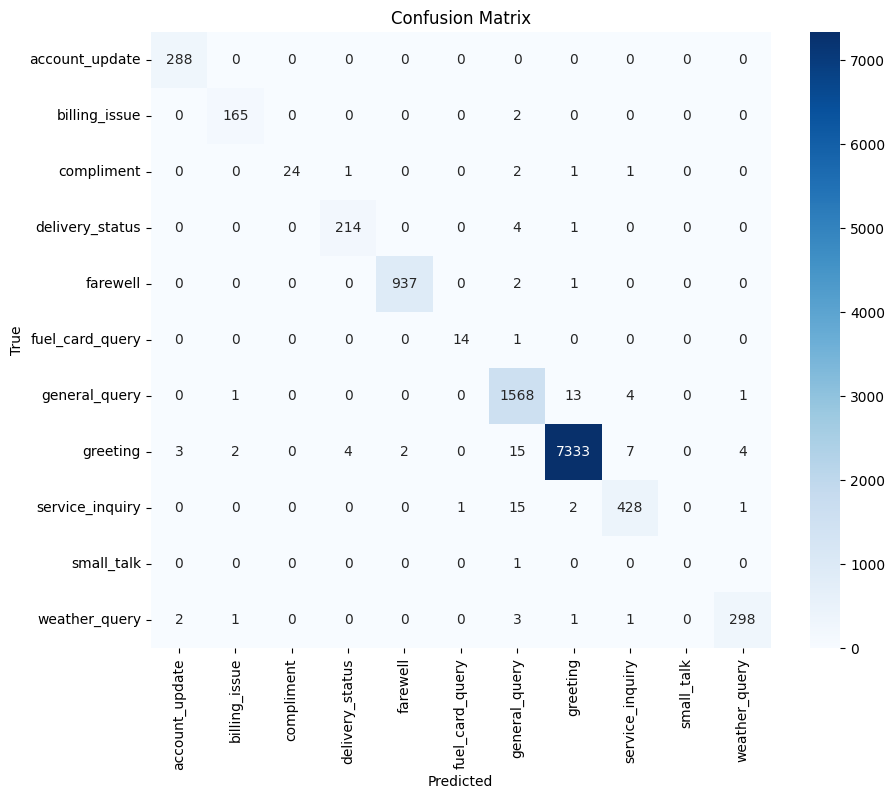

In [15]:
def evaluate_model(trainer, eval_dataset, label_map, unique_labels):
    try:
        predictions = trainer.predict(eval_dataset)
        preds = np.argmax(predictions.predictions, axis=1)
        labels = predictions.label_ids

        # Map unique_labels back to intent names
        reverse_label_map = {v: k for k, v in label_map.items()}
        target_names = [reverse_label_map[label] for label in unique_labels]

        accuracy = accuracy_score(labels, preds)
        report = classification_report(
            labels,
            preds,
            labels=unique_labels,
            target_names=target_names,
            zero_division=0
        )
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Classification Report:\n{report}\n')

        cm = confusion_matrix(labels, preds, labels=unique_labels)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
    except Exception as e:
        print(f'Error evaluating model: {e}')

evaluate_model(trainer, eval_dataset, label_map, unique_labels)


## Step 8: Dialogue Management


In [16]:
class DialogueManager:
    def __init__(self, model, tokenizer, label_map, dialoggpt_model, dialoggpt_tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.dialoggpt_model = dialoggpt_model
        self.dialoggpt_tokenizer = dialoggpt_tokenizer
        self.reverse_label_map = {v: k for k, v in label_map.items()}
        self.state = 'INITIAL'
        self.context = defaultdict(str)
        self.history = []
        self.fallback_responses = {
            'greeting': {
                'INITIAL': [
                    'Hello! How can I assist you with your trucking needs today?',
                    'Hi there! What can I help you with regarding your shipments or account?'
                ],
                'POST_GREETING': [
                    'Thanks for the greeting! How can I assist with your shipment or billing needs?',
                    'Nice to connect again! What’s on your mind today?'
                ]
            },
            'farewell': {
                'INITIAL': [
                    'Goodbye! Feel free to reach out if you need further assistance.',
                    'Thanks for connecting! Let me know if you have more questions later.'
                ]
            },
            'small_talk': {
                'INITIAL': {
                    'mood': ['My day’s going smoothly, thanks for asking! How’s yours?'],
                    'plans': ['No big plans here, just helping truckers! Got any big plans yourself?'],
                    'industry': ['Trucking life’s always moving! How’s it treating you these days?'],
                    'default': ['All’s well here, thanks for asking! Need help with your shipments?']
                }
            },
            'compliment': {
                'INITIAL': ['Thank you, that’s kind of you! How can I assist you today?']
            },
            'weather_query': {
                'INITIAL': ['Weather’s clear here, but I can check for your route! Where are you headed?']
            }
        }
        self.trucking_responses = {
            'delivery_status': {
                'INITIAL': 'I can check your shipment status for {location}. Please provide the shipment ID.',
                'AWAITING_SHIPMENT_ID': 'Could you share the shipment ID to proceed with tracking?',
                'PROVIDED_SHIPMENT_ID': 'Thank you. Shipment {shipment_id} is currently at {location}. Would you like the estimated arrival time?'
            },
            'billing_issue': {
                'INITIAL': 'Let’s review your billing issue with {company}. Is this about an overcharge or a payment concern?',
                'AWAITING_DETAILS': 'Can you provide the invoice number or {company} transaction amount?',
                'RESOLVING': 'I’ve noted a {amount} charge on your {company} invoice. Would you like to dispute this?'
            },
            'account_update': {
                'INITIAL': 'I can help update your account details for {regulation}. What information would you like to change?',
                'AWAITING_INFO': 'Please provide the new address or contact details for {regulation}.',
                'CONFIRMING': 'I have {new_info} for your {regulation} update. Please confirm to proceed.'
            },
            'service_inquiry': {
                'INITIAL': 'I can provide information on our services. Are you interested in flatbed, refrigerated, or bulk transport rates?',
                'AWAITING_SPECIFICS': 'Which service are you inquiring about: flatbed, refrigerated, or bulk transport?'
            },
            'fuel_card_query': {
                'INITIAL': 'I can assist with your {company} fuel card or {regulation} query. Is this about a balance, transaction, or compliance?',
                'AWAITING_DETAILS': 'Could you specify if this is a {company} card issue or a {regulation} tax question?'
            },
            'general_query': {
                'INITIAL': 'Could you clarify your request? I can help with delivery, billing, account updates, or {company}/{regulation} services.'
            }
        }

    def predict_intent(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = self.model(**inputs)
            predicted_label = torch.argmax(outputs.logits, dim=1).item()
        return self.reverse_label_map.get(predicted_label, 'general_query')  # Fallback to general_query

    def extract_entities(self, text):
        entities = []
        text = text.lower()
        if 'speedway' in text:
            entities.append({'entity': 'location', 'value': 'Speedway'})
        if 'comdata' in text:
            entities.append({'entity': 'company', 'value': 'Comdata'})
        if 'ifta' in text:
            entities.append({'entity': 'regulation', 'value': 'IFTA'})
        shipment_match = re.search(r'\bship\d+\b', text, re.IGNORECASE)
        if shipment_match:
            entities.append({'entity': 'shipment_id', 'value': shipment_match.group()})
        amount_match = re.search(r'\$\d+', text)
        if amount_match:
            entities.append({'entity': 'amount', 'value': amount_match.group()})
        if 'new address' in text or 'change to' in text:
            new_info = text.split('new address')[-1].strip() or text.split('change to')[-1].strip()
            entities.append({'entity': 'new_info', 'value': new_info[:50]})
        return entities

    def get_dialoggpt_response(self, text):
        try:
            if self.dialoggpt_tokenizer.pad_token is None:
                self.dialoggpt_tokenizer.pad_token = self.dialoggpt_tokenizer.eos_token
            input_ids = self.dialoggpt_tokenizer.encode(text + self.dialoggpt_tokenizer.eos_token, return_tensors='pt')
            reply_ids = self.dialoggpt_model.generate(
                input_ids,
                max_new_tokens=128,
                pad_token_id=self.dialoggpt_tokenizer.eos_token_id,
                no_repeat_ngram_size=3,
                top_p=0.9,
                temperature=0.7,
                do_sample=True
            )
            response = self.dialoggpt_tokenizer.decode(reply_ids[:, input_ids.shape[-1]:][0], skip_special_tokens=True)
            return response
        except Exception as e:
            print(f'Error getting DialogGPT response: {e}')
            return None

    def update_context(self, intent, entities, text):
        self.history.append((intent, text, ''))
        for entity in entities:
            self.context[entity['entity']] = entity['value']
        if intent == 'greeting':
            self.context['greeted'] = 'true'
        if intent == 'small_talk':
            text = text.lower()
            if 'day' in text or 'how’s your day' in text:
                self.context['small_talk_type'] = 'mood'
            elif 'plans' in text or 'big plans' in text:
                self.context['small_talk_type'] = 'plans'
            elif 'trucking' in text or 'truck' in text:
                self.context['small_talk_type'] = 'industry'
            else:
                self.context['small_talk_type'] = 'default'

    def transition_state(self, intent, entities, text):
        if intent in ['greeting', 'small_talk', 'compliment', 'weather_query']:
            self.state = 'POST_GREETING' if self.state == 'INITIAL' and intent == 'greeting' else self.state
        elif intent == 'farewell':
            self.state = 'INITIAL'
        elif intent == 'delivery_status':
            if self.state == 'INITIAL' and 'shipment_id' not in self.context:
                self.state = 'AWAITING_SHIPMENT_ID'
            elif 'shipment_id' in self.context:
                self.state = 'PROVIDED_SHIPMENT_ID'
        elif intent == 'billing_issue':
            if self.state == 'INITIAL' and not any(e['entity'] in ['amount', 'transaction_id'] for e in entities):
                self.state = 'AWAITING_DETAILS'
            elif any(e['entity'] in ['amount', 'transaction_id'] for e in entities):
                self.state = 'RESOLVING'
        elif intent == 'account_update':
            if self.state == 'INITIAL' and 'new_info' not in self.context:
                self.state = 'AWAITING_INFO'
            elif 'new_info' in self.context:
                self.state = 'CONFIRMING'
        elif intent == 'service_inquiry':
            if self.state == 'INITIAL' and 'service_type' not in self.context:
                self.state = 'AWAITING_SPECIFICS'
        elif intent == 'fuel_card_query':
            if self.state == 'INITIAL' and not any(e['entity'] in ['balance', 'transaction'] for e in entities):
                self.state = 'AWAITING_DETAILS'

    def generate_response(self, intent, entities, text):
        self.update_context(intent, entities, text)
        self.transition_state(intent, entities, text)

        if intent in ['greeting', 'farewell', 'small_talk', 'compliment', 'weather_query']:
            dialog_response = self.get_dialoggpt_response(text)
            if not dialog_response or len(dialog_response) < 5 or any(word in dialog_response.lower() for word in ['inappropriate', 'sorry', 'weird', 'lol']):
                small_talk_type = self.context.get('small_talk_type', 'default')
                if intent == 'small_talk':
                    response_options = self.fallback_responses[intent]['INITIAL'].get(small_talk_type, self.fallback_responses[intent]['INITIAL']['default'])
                else:
                    response_options = self.fallback_responses.get(intent, {'INITIAL': ['Could you clarify your request?']}).get(self.state, self.fallback_responses[intent]['INITIAL'])
                response = random.choice(response_options) if isinstance(response_options, list) else response_options
            else:
                response = dialog_response + ' Need assistance with your trucking needs?'
            if intent == 'greeting' and 'good morning' in text.lower() and datetime.now().hour < 12:
                response = random.choice(['Good morning to you too! How can I assist today?', 'Morning! Ready to help with your trucking needs.'])
        else:
            response_template = self.trucking_responses.get(intent, self.trucking_responses['general_query']).get(self.state, self.trucking_responses[intent]['INITIAL'])
            try:
                response = response_template.format(
                    location=self.context.get('location', 'unknown'),
                    company=self.context.get('company', 'unknown'),
                    regulation=self.context.get('regulation', 'unknown'),
                    shipment_id=self.context.get('shipment_id', 'unknown'),
                    amount=self.context.get('amount', 'unknown'),
                    new_info=self.context.get('new_info', 'unknown')
                )
            except KeyError:
                response = response_template

        if self.context.get('greeted') == 'true' and intent not in ['greeting', 'farewell', 'small_talk', 'compliment', 'weather_query'] and 'PROVIDED' in self.state:
            response = f'Since you greeted me earlier, I’m ready to assist! {response}'

        self.history[-1] = (intent, text, response)
        resolved = self.state in ['PROVIDED_SHIPMENT_ID', 'RESOLVING', 'CONFIRMING'] and intent not in ['greeting', 'farewell', 'small_talk', 'compliment', 'weather_query']
        return response, resolved

    def evaluate_dialogue_success(self):
        resolved = sum(1 for intent, _, _ in self.history if intent not in ['greeting', 'farewell', 'small_talk', 'compliment', 'weather_query'] and self.state in ['PROVIDED_SHIPMENT_ID', 'RESOLVING', 'CONFIRMING'])
        total = sum(1 for intent, _, _ in self.history if intent not in ['greeting', 'farewell', 'small_talk', 'compliment', 'weather_query'])
        return resolved / total if total > 0 else 0.0

try:
    with open('label_map.json', 'r') as f:
        label_map = json.load(f)
    dialogue_manager = DialogueManager(model, tokenizer, label_map, dialoggpt_model, dialoggpt_tokenizer)
except FileNotFoundError:
    print('Error: label_map.json not found. Please ensure Cell 6 has run successfully.')
    dialogue_manager = None


In [17]:
!jupyter nbextension enable --py widgetsnbextension
from google.colab import output
output.enable_custom_widget_manager()

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


## Step 9: Interactive Chatbot UI

UI with DialogGPT conversational support trained on Twitter data.

In [18]:
if dialogue_manager is None:
    print('Dialogue manager not initialized. Please fix previous errors.')
else:
    # Create UI
    input_box = widgets.Text(
        value='',
        placeholder='Type your query (e.g., Hello, How’s your day?, or Where’s my shipment?)',
        description='Query:',
        layout={'width': '500px'}
    )
    submit_button = widgets.Button(
        description='Submit',
        button_style='success',
        tooltip='Submit query'
    )
    follow_up_button1 = widgets.Button(
        description='Request ETA',
        button_style='info',
        tooltip='Request ETA',
        layout={'visibility': 'hidden'}
    )
    follow_up_button2 = widgets.Button(
        description='Confirm',
        button_style='success',
        tooltip='Confirm action',
        layout={'visibility': 'hidden'}
    )
    output_area = widgets.Output()

    def on_submit_clicked(b):
        with output_area:
           # clear_output()
            user_input = input_box.value.strip()
            if not user_input:
                print('Please enter a query.')
                return
            print(f'You: {user_input}')
            try:
                intent = dialogue_manager.predict_intent(user_input)
                entities = dialogue_manager.extract_entities(user_input)
                response, resolved = dialogue_manager.generate_response(intent, entities, user_input)
                print(f'Bot: {response}')
                input_box.value = ''
                follow_up_button1.layout.visibility = 'visible' if dialogue_manager.state == 'PROVIDED_SHIPMENT_ID' else 'hidden'
                follow_up_button2.layout.visibility = 'visible' if dialogue_manager.state in ['RESOLVING', 'CONFIRMING'] else 'hidden'
                success_rate = dialogue_manager.evaluate_dialogue_success()
                if success_rate > 0:
                    print(f'Dialogue Success Rate: {success_rate:.2f}')
            except Exception as e:
                print(f'Error processing query: {e}')

    def on_follow_up1_clicked(b):
        with output_area:
            #clear_output()
            response = f'The estimated arrival time for shipment {dialogue_manager.context.get("shipment_id", "unknown")} is tomorrow by 3 PM.'
            dialogue_manager.history.append(('follow_up', 'Request ETA', response))
            print(f'Bot: {response}')
            follow_up_button1.layout.visibility = 'hidden'
            success_rate = dialogue_manager.evaluate_dialogue_success()
            if success_rate > 0:
                print(f'Dialogue Success Rate: {success_rate:.2f}')

    def on_follow_up2_clicked(b):
        with output_area:
            #clear_output()
            if dialogue_manager.state == 'CONFIRMING':
                response = f'Confirmed. {dialogue_manager.context.get("new_info", "action")} has been updated.'
            else:
                response = f'Dispute for {dialogue_manager.context.get("amount", "unknown")} has been submitted.'
            dialogue_manager.history.append(('follow_up', 'Confirm', response))
            dialogue_manager.state = 'INITIAL'
            print(f'Bot: {response}')
            follow_up_button2.layout.visibility = 'hidden'
            success_rate = dialogue_manager.evaluate_dialogue_success()
            if success_rate > 0:
                print(f'Dialogue Success Rate: {success_rate:.2f}')

    submit_button.on_click(on_submit_clicked)
    follow_up_button1.on_click(on_follow_up1_clicked)
    follow_up_button2.on_click(on_follow_up2_clicked)
    print('before display')
    display("test")
    # Display UI
    display(widgets.VBox([
        widgets.HTML('<h3>Trucking Co. Customer Chatbot</h3>'),
        input_box,
        submit_button,
        follow_up_button1,
        follow_up_button2,
        output_area
    ]))
    print('Welcome! You can greet me, chat about your day, or ask about delivery, billing, or Comdata/IFTA services.')
    print('Type your query and click Submit.')


before display


'test'

Welcome! You can greet me, chat about your day, or ask about delivery, billing, or Comdata/IFTA services.
Type your query and click Submit.


In [27]:
!pip show ipywidgets

Name: ipywidgets
Version: 8.1.5
Summary: Jupyter interactive widgets
Home-page: http://jupyter.org
Author: Jupyter Development Team
Author-email: jupyter@googlegroups.com
License: BSD 3-Clause License
Location: /usr/local/lib/python3.11/dist-packages
Requires: comm, ipython, jupyterlab-widgets, traitlets, widgetsnbextension
Required-by: bigframes, bigquery-magics, bqplot, cufflinks, ipyevents, ipyfilechooser, ipyleaflet, ipytree, spanner-graph-notebook
